# Setup and Data Loading
Start by importing necessary libraries and loading the data

In [42]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Set seed for reproducibility
np.random.seed(1234)

# load the data
# add as header the columns names: statement_id, label, statement, subject, speaker, job_title, state, party, barely_true_c, false_c, half_true_c, mostly_true_c, pants_on_fire_c, context
header = ['statement_id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'context']
test_data = pd.read_csv('./liar_dataset/test.tsv', sep='\t', names=header)
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', names=header)
valid_data = pd.read_csv('./liar_dataset/valid.tsv', sep='\t', names=header)
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   statement_id     10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10238 non-null  object 
 4   speaker          10238 non-null  object 
 5   job_title        7342 non-null   object 
 6   state            8030 non-null   object 
 7   party            10238 non-null  object 
 8   barely_true_c    10238 non-null  float64
 9   false_c          10238 non-null  float64
 10  half_true_c      10238 non-null  float64
 11  mostly_true_c    10238 non-null  float64
 12  pants_on_fire_c  10238 non-null  float64
 13  context          10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


clean the data and check for missing values

In [44]:
# show me the NA number for each column
train_data.isnull().sum()


statement_id          0
label                 0
statement             0
subject               2
speaker               2
job_title          2898
state              2210
party                 2
barely_true_c         2
false_c               2
half_true_c           2
mostly_true_c         2
pants_on_fire_c       2
context             102
dtype: int64

In [45]:
# take off the 2 rows that cintain in all the columns NA
# show me the row with the NA in the spkear column
train_data[train_data.speaker.isnull()]
# drop the row with the NA in the spkear column and reset the index
train_data.dropna(subset=['speaker'], inplace=True)
train_data.reset_index(drop=True, inplace=True)
train_data.isnull().sum()

statement_id          0
label                 0
statement             0
subject               0
speaker               0
job_title          2896
state              2208
party                 0
barely_true_c         0
false_c               0
half_true_c           0
mostly_true_c         0
pants_on_fire_c       0
context             100
dtype: int64

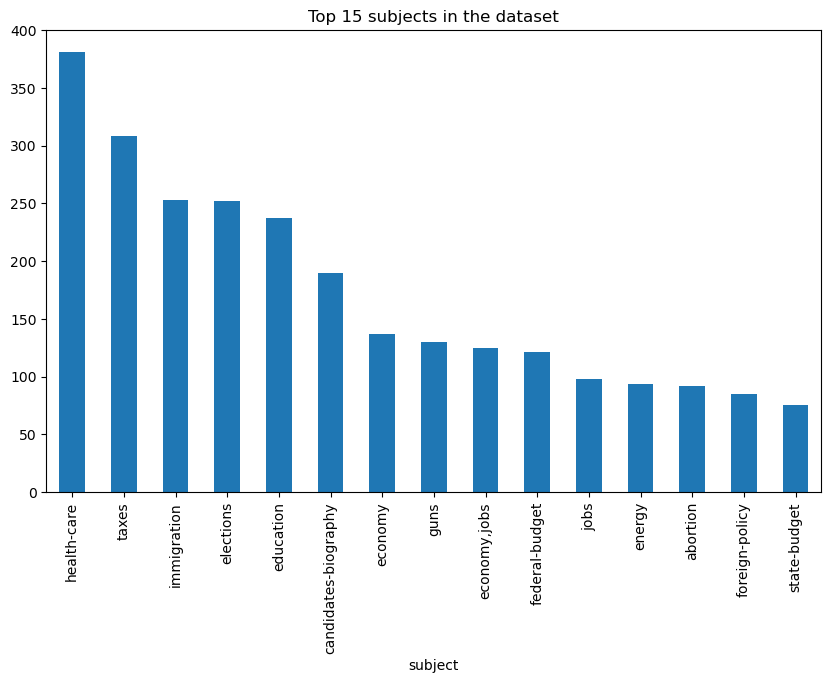

In [46]:
# show the distrubution of the the subject column show the top 15

train_data['subject'].value_counts().head(15).plot(kind='bar', figsize=(10, 6), title='Top 15 subjects in the dataset')
plt.show()

In [47]:
# print the rows with NA values
train_data[train_data['job_title'].isnull()]

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website
13,8616.json,mostly-true,The economy bled $24 billion due to the govern...,"economy,federal-budget,health-care",doonesbury,NaN,NaN,none,0.0,0.0,2.0,4.0,0.0,a Doonesbury strip in the Sunday comics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,1592.json,half-true,"Under the ruling of the Supreme Court, any lob...","corporations,elections",david-axelrod,NaN,NaN,democrat,2.0,1.0,6.0,7.0,0.0,an interview on ABC's This Week
10233,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10234,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10235,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate


In [48]:
# for thw rows with NA values in the job_title column, print the unique values of the context column
train_data[train_data['job_title'].isnull()]['context'].unique()

array(['a news release', 'an interview on CNN', 'a press release.', ...,
       'a recorded telephone message to Cranston residents',
       'interview on "The Colbert Report"',
       "a televised debate on Miami's WPLG-10 against Kendrick Meek."],
      dtype=object)

# Text Preprocessing
Next, preprocess the text data:

In [55]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Preprocess the text with handling for hyphenated words
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    # Allow hyphenated words by checking if the word is either alphanumeric or contains hyphens
    tokens = [word for word in tokens if all(part.isalnum() for part in word.split('-')) and word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply the updated function to the columns
train_data['processed_text'] = train_data['statement'].apply(preprocess_text)
train_data['processed_job_title'] = train_data['job_title'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
train_data['processed_subject'] = train_data['subject'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
train_data['processed_state'] = train_data['state'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
train_data['processed_context'] = train_data['context'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Feature Engineering for Text Data

In [58]:
# Function to average word vectors of column values
def get_average_word2vec(tokens, model, vector_size):
    if len(tokens) < 1:
        return np.zeros(vector_size)
    vecs = [model.wv[token] for token in tokens if token in model.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)

In [24]:
# statement - will be used to generate new features

In [64]:
# Subject - word to vec embedding

# Train a Word2Vec model on the processed subjects
subject_model = Word2Vec(sentences=train_data['processed_subject'], vector_size=200, window=10, min_count=1, workers=4)


# Apply the function to the 'processed_subject' column and save the embedding as a list
vector_size = subject_model.vector_size
train_data['subject_embedding'] = train_data['processed_subject'].apply(lambda x: get_average_word2vec(x, subject_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
train_data[['subject', 'subject_embedding']]







,subject,subject_embedding
0,abortion,"[0.011777314357459545, -0.06361104547977448, -..."
1,"energy,history,job-accomplishments","[0.010776174254715443, -0.09115904569625854, -..."
2,foreign-policy,"[0.018474631011486053, -0.09211907535791397, -..."
3,health-care,"[0.01490850280970335, -0.08456657081842422, -0..."
4,"economy,jobs","[0.017820868641138077, -0.08373109996318817, -..."
...,...,...
10233,"animals,elections","[0.011441091075539589, -0.08897936344146729, -..."
10234,elections,"[0.014039146713912487, -0.08307032287120819, -..."
10235,"retirement,social-security","[0.013419020920991898, -0.07846865803003311, -..."
10236,"florida,foreign-policy","[0.013374410569667816, -0.08050502836704254, -..."


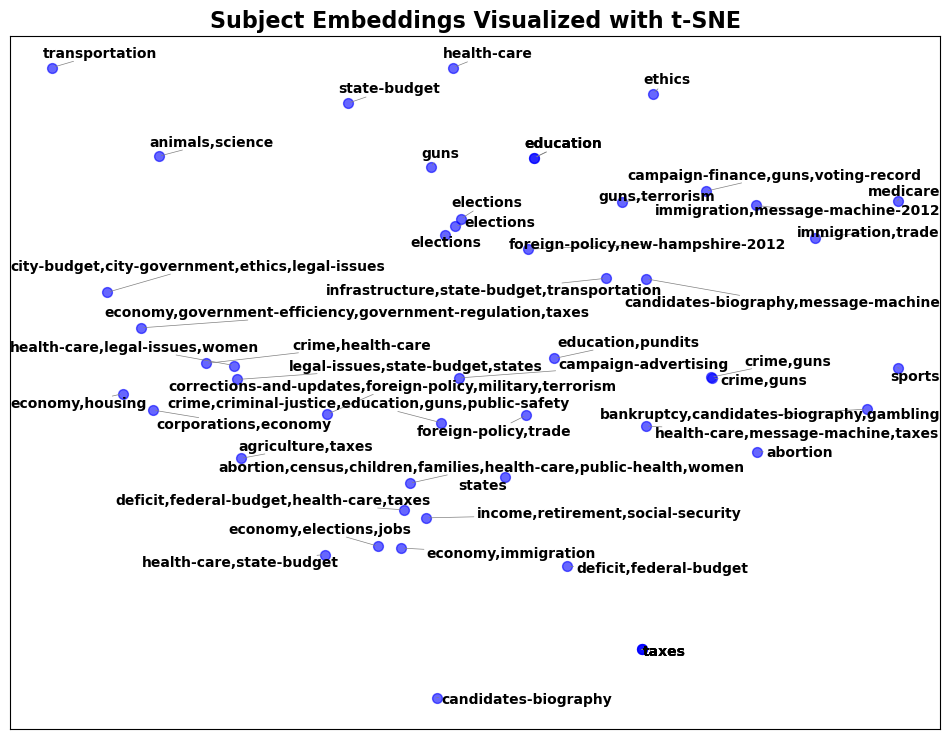

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(train_data['subject_embedding'].tolist())
subjects_filtered = train_data['subject'].values  # Use 'subject' instead of embeddings for text

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Reduce figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], subjects_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Subject Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


In [26]:
# speaker - dont use it and use counts of the speaker labels

# Feature Engineering: Job Title Embeddings
Train a Word2Vec model on the job titles:

,job_title,job_title_embedding
0,State representative,"[0.004437975585460663, -0.04875877499580383, -..."
1,State delegate,"[0.00040030444506555796, -0.030450254678726196..."
2,President,"[0.020807888358831406, -0.08828122913837433, -..."
3,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


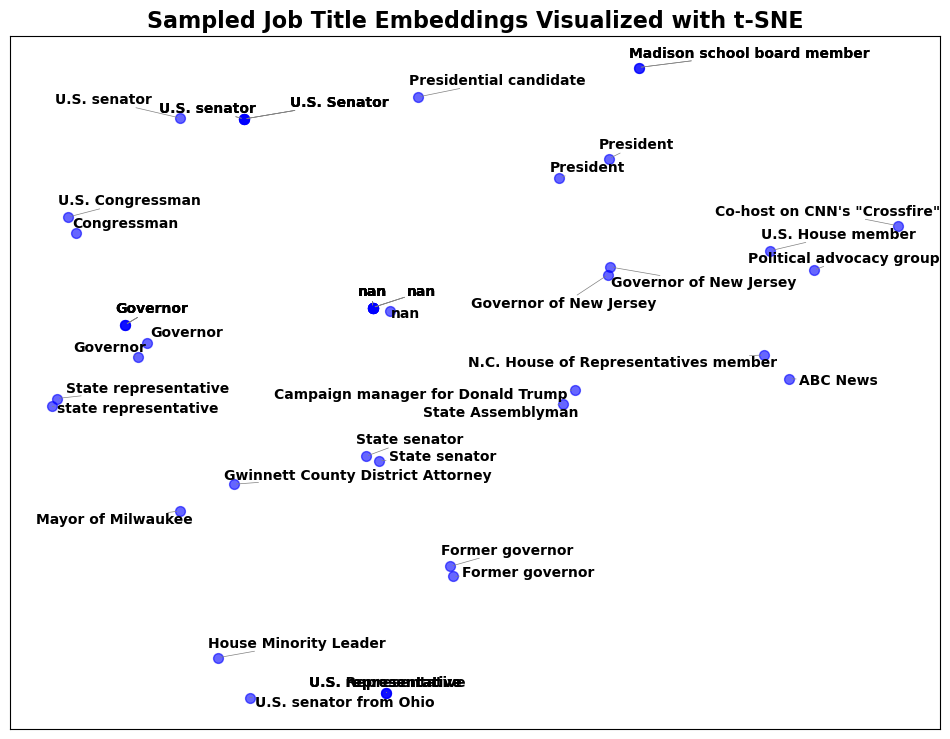

In [66]:
# job_title - word to vec embedding

# Train a Word2Vec model on the processed job titles
job_title_model = Word2Vec(sentences=train_data['processed_job_title'], vector_size=200, window=10, min_count=1, workers=4)

# Apply the function to the 'processed_job_title' column and save the embedding as a list
vector_size = job_title_model.vector_size
train_data['job_title_embedding'] = train_data['processed_job_title'].apply(lambda x: get_average_word2vec(x, job_title_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
display(train_data[['job_title', 'job_title_embedding']].head())

# Visualize the embeddings using t-SNE

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(train_data['job_title_embedding'].tolist())
job_titles_filtered = train_data['job_title'].values  # Use 'job_title' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], job_titles_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Sampled Job Title Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


In [72]:
# state 
# print all the states in the dataset and the number of times they appear
train_data['state'].value_counts()
# chose not to use this data.




state
Texas             1009
Florida            997
Wisconsin          713
New York           657
Illinois           556
                  ... 
Qatar                1
ohio                 1
Virginia             1
United Kingdom       1
Rhode Island         1
Name: count, Length: 83, dtype: int64

# Label Encoding for Party Affiliation
This section encodes the party affiliation of the politicians.

In [73]:
# party - 
# get info on party column, the different values and the number of samples for each value
train_data['party'].value_counts()
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'party' column
train_data['party_encoded'] = label_encoder.fit_transform(train_data['party'])

# Display the first few rows to verify the result
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,...,pants_on_fire_c,context,processed_text,processed_job_title,processed_subject,processed_state,processed_context,subject_embedding,job_title_embedding,party_encoded
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0.0,a mailer,"[say, annies, list, political, group, support,...","[state, representative]",[abortion],[texas],[mailer],"[0.011777314357459545, -0.06361104547977448, -...","[0.004437975585460663, -0.04875877499580383, -...",19
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,0.0,a floor speech.,"[decline, coal, start, started, natural, gas, ...","[state, delegate]","[energy, history, job-accomplishments]",[virginia],"[floor, speech]","[0.010776174254715443, -0.09115904569625854, -...","[0.00040030444506555796, -0.030450254678726196...",5
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,9.0,Denver,"[hillary, clinton, agrees, john, mccain, votin...",[president],[foreign-policy],[illinois],[denver],"[0.018474631011486053, -0.09211907535791397, -...","[0.020807888358831406, -0.08828122913837433, -...",5
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,44.0,a news release,"[health, care, reform, legislation, likely, ma...",[],[health-care],[],"[news, release]","[0.01490850280970335, -0.08456657081842422, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,2.0,an interview on CNN,"[economic, turnaround, started, end, term]",[],"[economy, job]",[florida],"[interview, cnn]","[0.017820868641138077, -0.08373109996318817, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5


In [30]:
# counts of the speaker labels - use as is.

In [75]:
# context - docs2vec embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
import numpy as np


# Create TaggedDocuments for the Doc2Vec model (each document is a list of tokens from 'context')
documents = [TaggedDocument(words=row, tags=[i]) for i, row in enumerate(train_data['processed_context'])]

# Train a Doc2Vec model
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

# Generate Doc2Vec embeddings for each 'context'
train_data['context_embedding'] = train_data['processed_context'].apply(lambda x: doc2vec_model.infer_vector(x))

# Display the first few rows with context embeddings
display(train_data[['context', 'context_embedding']].head())

,context,context_embedding
0,a mailer,"[-0.050565846, -0.0044059954, -0.05242145, -0...."
1,a floor speech.,"[-0.036483765, 0.0014586254, -0.024663992, -0...."
2,Denver,"[-0.08656635, 0.0005532338, -0.041045733, -0.0..."
3,a news release,"[-0.019891782, 0.0011756297, 0.012283027, -0.0..."
4,an interview on CNN,"[-0.05471232, -0.004056982, 0.02304198, 0.0005..."


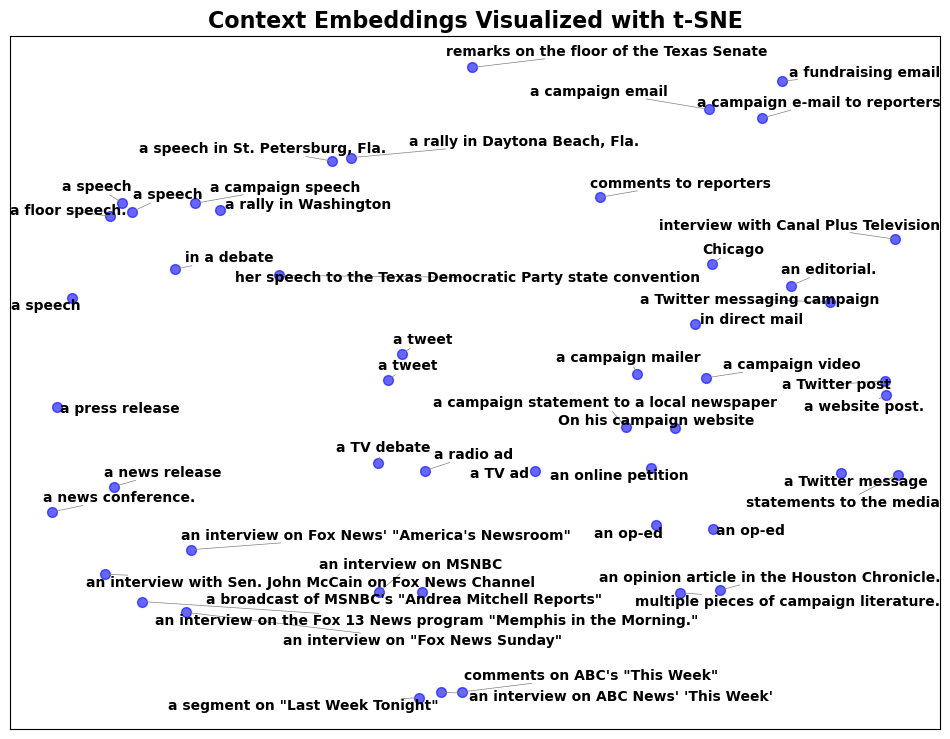

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Extract the embeddings and context after filtering
embeddings_filtered = np.array(train_data['context_embedding'].tolist())
context_filtered = train_data['context'].values  # Use 'context' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with context for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], context_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Context Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


Build a basic ML model with the current features and evaluate its performance.

In [32]:
# topic modeling - LDA